['./memorial/memorial0061.png', './memorial/memorial0062.png', './memorial/memorial0063.png', './memorial/memorial0064.png', './memorial/memorial0065.png', './memorial/memorial0066.png', './memorial/memorial0067.png', './memorial/memorial0068.png', './memorial/memorial0069.png', './memorial/memorial0070.png', './memorial/memorial0071.png', './memorial/memorial0072.png', './memorial/memorial0073.png', './memorial/memorial0074.png', './memorial/memorial0075.png', './memorial/memorial0076.png']
[32.0, 16.0, 8.0, 4.0, 2.0, 1.0, 0.5, 0.25, 0.125, 0.0625, 0.03125, 0.015625, 0.0078125, 0.00390625, 0.001953125, 0.0009765625]


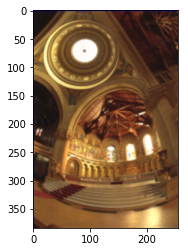

(256, 384, 6655, 656)
Compute rgb = 0
((6655, 656), (6655, 1))
Compute rgb = 1
((6655, 656), (6655, 1))
Compute rgb = 2
((6655, 656), (6655, 1))


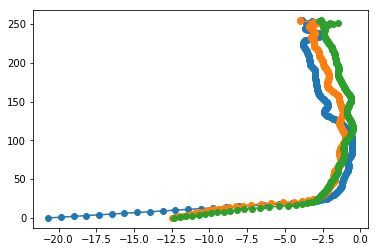

Getting HDR Image ...
(0.0012072903, 0.17735851)
(0.0036537501, 0.14619559)
(0.0020808743, 0.18220067)


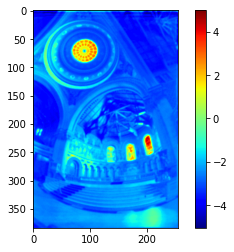

Tonemapping ........
(384, 256, 3)


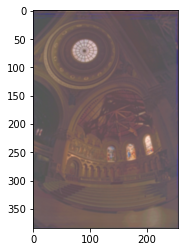

End


In [2]:
from matplotlib import pyplot as plt
from IPython.display import Image
from subprocess import call
import matplotlib as mp
import numpy as np
import subprocess
import random
import cv2
import glob

class HDR():
    def __init__(self):
        """
        images record the RGB image matrix
        width: picture's width
        height: picture's height
        zMid: energy middle number
        """
        self.images = list()
        self.width = 0
        self.height = 0
        self.zMid = 128
    
    """
    Read the sorted images from files
    """
    def showImg(self, img=None):
        imgs = self.images
        if img is not None:
            imgs = [img]
    
        for img in imgs:
            tarImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow(tarImg, interpolation='bicubic')
            plt.show()
    
    def readImg(self, imgs):
        for imgName in imgs:
            # img = cv2.cvtColor(cv2.imread (imgName), cv2.COLOR_BGR2RGB)
            img = cv2.imread(imgName)
            sImg = cv2.resize(img, (0,0), fx=0.5, fy=0.5)
            self.images.append(sImg)
        
        if len(self.images) > 0:
            img = self.images[0]
            (h, w, rgb) = self.images[0].shape
            self.height = h
            self.width = w
            self.rgb = rgb

    def getImg(self, index):
        return self.images[index]
    
    def setAttr(self, Lambda=1, expTime=list(), sampleCount=1):
        """
        Configure the attribute for HDR
        - Lambda: lmabda number for smooth function
        - expTime: Exposure time configured in input picture set
        - sampleCount: number of energy point sampled in the pictures
        """
        self.Lambda = Lambda
        self.expTime = expTime
        self.sampleCount = sampleCount
    
    def weightFunc(self, z):
        if z <= self.zMid:
            return z
        else:
            return 255 - z 
    
    def getApproxFunc(self):
        w = self.width
        h = self.height
        n = self.sampleCount
        p = len(self.images) # Number of images
        matrixRow = n * p + 255 # h of A
        matrixCol = 256 + n # w of A
        print(w,h,matrixRow, matrixCol)
        A = np.zeros([3, matrixRow, matrixCol], 'float32')
        B = np.zeros([3, matrixRow, 1], 'float32')
        X = np.zeros([3, matrixCol, 1], 'float32')
        
        """
        Initialize samples
        """
        samples = list()
        for _ in range(0, self.sampleCount):
            i = random.randint(0, self.height - 1)
            j = random.randint(0, self.width - 1)
            samples.append((i, j))
        
        """
        Fill the upper matrix
        """
        self.gFunc = list()
        for rgb in range(0,3):
            k = 0
            sampleIdx = 0
            for i, j in samples:
                for picIdx in range(0, p):
                    image = self.images[picIdx]
                    mRow = k
                    mCol = image[i][j][rgb]
                    weight = self.weightFunc(mCol)
                    A[rgb][mRow][mCol] = 1.0 * weight        # Left-Upper Matrix
                    A[rgb][mRow][mCol+sampleIdx] = -1.0 * weight # Right-Upper Matrix
                    B[rgb][mRow][0] = np.log(self.expTime[picIdx]) * 1.0 * weight # log(delta_t)
                    k = k + 1 # Update current column in the matrix
                sampleIdx = sampleIdx + 1
            
            A[rgb][k][self.zMid] = 1 # 1 * g(128) =  b[128][0] = 0
            k = k + 1
            
            for i in range(0,254):
                weight = self.weightFunc(i+1)
                l = self.Lambda
                A[rgb][k][i] = l * weight
                A[rgb][k][i+1] = l * (-2) * weight
                A[rgb][k][i+2] = l * weight
                k = k + 1 # Update value of k
            
            print("Compute rgb = %s" % rgb)
            """
            (U, sigma, VT) = np.linalg.svd(A[rgb])
            S = np.zeros([U.shape[0], VT.shape[0]])
            
            # Convert sigma (one dim vector) to m x n matrix
            S[:VT.shape[0], :VT.shape[0]] = np.diag(sigma)
            
            # Compute pseudo inverse matrix
            VTISI = np.dot(VT.T, np.linalg.pinv(S))
            PInvMat = np.dot(VTISI, U.T)
            
            # Find solution for X
            X[rgb] = np.dot(PInvMat, B[rgb])
            """
            print(A[rgb].shape, B[rgb].shape)
            X[rgb] = np.linalg.lstsq(A[rgb], B[rgb])[0]
            # X[rgb][0] = 0
            self.gFunc.append(X[rgb].T.tolist()[0][0:256])
            # print(U.shape, sigma.shape, S.shape, VT.shape)
        
        plt.plot(self.gFunc[0], range(0, 256), marker='o')
        plt.plot(self.gFunc[1], range(0, 256), marker='o')
        plt.plot(self.gFunc[2], range(0, 256), marker='o')
        plt.show()
        self.X = X
        
    def getHDRImage(self):
        print("Getting HDR Image ...")
        hdrImage = np.zeros([self.height, self.width, 3], 'float32')
        for rgb in range(0, 3):
            for h in range(0, self.height):
                for w in range(0, self.width):
                    hdrImage[h][w][rgb] = 0.0
                    totalWeight = 0.0
                    expSum = 0.0
                    for idx, img in enumerate(self.images):
                        z = img[h][w][rgb]
                        weight = self.weightFunc(z)
                        totalWeight += weight
                        expSum += (weight * (self.gFunc[rgb][z] - np.log(self.expTime[idx])))
                    hdrImage[h][w][rgb] = np.exp(expSum / totalWeight)
            # zMin = np.amin(hdrImage[:][:][rgb])
            # zMax = np.amax(hdrImage[:][:][rgb])
            # print(zMin, zMax)
            # hdrImage[:][:][rgb] = (hdrImage[:][:][rgb] - zMin) / (zMax - zMin)  
    
        for rgb in range(0, 3):
            zMin = np.amin(hdrImage[:][:][rgb])
            zMax = np.amax(hdrImage[:][:][rgb])
            print(zMin, zMax)
            hdrImage[:][:][rgb] = (hdrImage[:][:][rgb] - zMin) / (zMax - zMin)  
        
        cv2.imwrite('myhdr.hdr', hdrImage)
        
        hdrImgUInt8 = np.clip(hdrImage * 255, 0, 255).astype('uint8')
        radMap = cv2.cvtColor(hdrImage, cv2.COLOR_BGR2GRAY)
        plt.imshow(np.log(radMap), cmap='jet', interpolation='bicubic')
        plt.colorbar()
        plt.show() 
        
        print("Tonemapping ........")
        toneMap = cv2.createTonemapDurand(gamma=4.4)
        toneImgFloat32 = toneMap.process(hdrImage.copy())
        toneImg = np.clip(toneImgFloat32 * 255, 0, 255).astype('uint8')
        
        
        print(toneImg.shape)
        # print(toneImg)
        self.showImg(img=toneImg)
        
        
def main():
    hdr = HDR()
    """
    expSample = [13.0, 10.0, 4.0, 3.2, 1, 0.8, 1.0/3, 1.0/4, 1.0/60, 1.0/80, 1.0/320, 1.0/400, 1.0/1000]
    images = glob.glob('./exposures/*')
    """
    
    expSample = list()
    images = glob.glob('./memorial/*')
    images.sort()
    fin = open('mem_exp.txt')
    while True:
        s = fin.readline()
        if not s:
            break
        expSample.append(1/float(s.split()[1]))
    fin.close()
    
    
    print(images)
    print(expSample)
    
    hdr.readImg(images)
    hdr.setAttr(Lambda=50, expTime=expSample, sampleCount=400)
    hdr.showImg(hdr.getImg(3))   
    hdr.getApproxFunc()
    hdr.getHDRImage()
    print('End')
    
if __name__ == "__main__":
    main()

(16, 16)
(768, 512, 3)


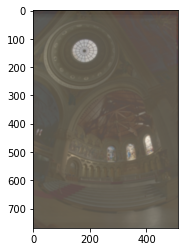

In [19]:
from matplotlib import pyplot as plt
import cv2
import glob
import numpy as np

    
expSample = [13.0, 10.0, 4.0, 3.2, 1, 0.8, 1.0/3, 1.0/4, 1.0/60, 1.0/80, 1.0/320, 1.0/400, 1.0/1000]
images = glob.glob('/home/chihmin/vfx/hw1/exposures/*')

"""
images = glob.glob('/home/chihmin/vfx/hw1/memorial/*')
images.sort()
fin = open('mem_exp.txt')
expSample = list()
while True:
    s = fin.readline()
    if not s:
        break
    expSample.append(1/float(s.split()[1]))
fin.close()
print(len(images), len(expSample))
"""


merge = cv2.createMergeDebevec()
expSample = np.array(expSample, dtype=np.float32)
img_list = [cv2.imread(fn) for fn in images]
img = merge.process(img_list, times=expSample)
tonemap1 = cv2.createTonemapDurand(gamma=3.3)
print(img.shape)
res_debvec = tonemap1.process(img.copy())
res_debvec_8bit = cv2.cvtColor(np.clip(res_debvec*255, 0, 255).astype('uint8'), cv2.COLOR_BGR2RGB)

plt.imshow(res_debvec_8bit, interpolation='bicubic')
plt.show()